In [1]:
import torch
import torch.nn as nn

# Description

Recurrent neural networks (RNNs) introduce the notion of a hidden state, similar to the hidden layers of multilayer perceptrons (MLPs). Let $X$ be an $n$-folded sequential data of dimension $k$ and length $T$. $n$ refers to the number of examples, $T$ is the sequence length and $k$ refers to the dimension of each datapoint in the sequence. For a scalar valued data such as weather, price etc. $d=1$. RNN is the set of following maps:

1. Each element in the input sequence is embedded into a larger space $$X_t\mapsto X_t W_{xh}^T$$
by an embedding matrix $W_{xh}\in\mathbb{R}^{d \times h}$. As one can perceive this space as a parameter space or configuration space, this operation amounts to parametrization of the sequence.

2. Initialize a hidden state with $H_{-1}\in\mathbb{R}^{n\times h}$ often with zeros. 
3. To capture the sequential relationship, multiply each element by a square matrix $W_{hh}\in\mathbb{R}^{h\times h}$ recursively and sum with $X_t W_{xh}^T$
4. Apply an activation function often (tanh) and define $t^{th}$ hidden state as $$H_t = \tanh(X_{t} W_{xh}^T + H_{t-1} \widetilde{W}_{hh}^T + b_h)$$

At the end, the sequence of the hidden state is projected to a vector space of desired dimension $O_t = H_t W_{hr}^T+b_r$ where $W_{hr}\in\mathbb{R}^{h\times r}$ If we work with scalar valued functions and would like to predict future values, $r=1$.


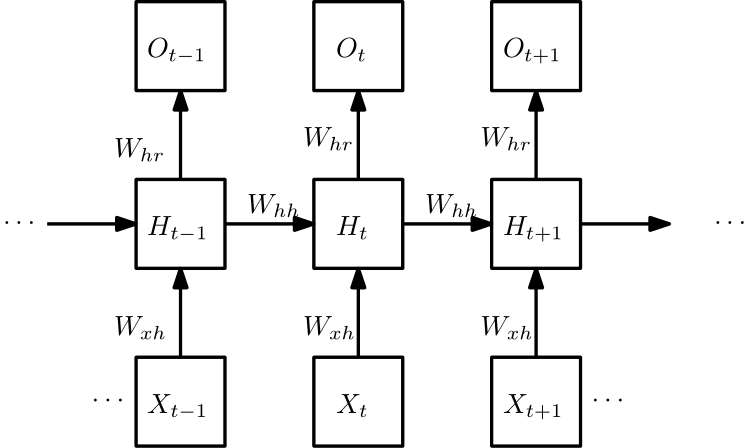

# nn.RNN from Scratch

## num_layers=1

Define RNN from scratch and compare it with nn.RNN from pytorch library. We ignore bias terms for simplicity.

In [2]:
def RNN_scratch(X, H, W_xh, W_hh):
    out_scratch = []
    for i in range(len(X)):
        H = torch.tanh(torch.matmul(X[i],W_xh)+torch.matmul(H,W_hh))
        out_scratch.append(H)
    out_scratch = torch.stack(out_scratch).reshape(len(X),len(W_hh))
    return out_scratch, H

In [3]:
X = torch.randn(1000,1)
H_in = torch.zeros(1,3)
my_RNN = nn.RNN(1,3,bias=False)
out, H_out = my_RNN(X, H_in)
print(f"input shape: {X.shape}, output shape: {out.shape}, hidden state shape: {H_out.shape}")

input shape: torch.Size([1000, 1]), output shape: torch.Size([1000, 3]), hidden state shape: torch.Size([1, 3])


In [4]:
all_params = list(my_RNN.parameters())
W_t = all_params[0].detach().transpose(0,1)
W_Bar_t = all_params[1].detach().transpose(0,1)
all_params

[Parameter containing:
 tensor([[0.4546],
         [0.3119],
         [0.4899]], requires_grad=True),
 Parameter containing:
 tensor([[-0.4554, -0.4969,  0.5397],
         [-0.2188,  0.4026, -0.4456],
         [ 0.2713, -0.4530, -0.2177]], requires_grad=True)]

In [5]:
out_scratch, H_out_scratch = RNN_scratch(X, H_in, W_t, W_Bar_t)

In [6]:
torch.allclose(out,out_scratch), torch.allclose(H_out, H_out_scratch) 

(True, True)

Our function `RNN_scratch` gives the same result as `nn.RNN`, which is faster since it uses compiled operators. To predict future values, we use a linear layer to project the hidden state to the output. Let's implement this and compare it with the `nn.Linear` operator.

In [7]:
def lin_scratch(X, W_hr):
    out_scratch = []
    for i in range(len(X)):
        output = torch.matmul(X[i],W_hr)
        out_scratch.append(output)
    out_scratch = torch.stack(out_scratch)
    return out_scratch

In [8]:
my_lin = nn.Linear(3,1,bias=False)
lin_out = my_lin(out_scratch)
my_params = list(my_lin.parameters())
W = my_params[0].detach().transpose(0,1)

In [9]:
lin_scratch_out = lin_scratch(out_scratch,W)
torch.allclose(lin_scratch_out, lin_out)

True

## num_layers = n

For more complex sequential data, we often need multilayer hidden states, which correspond to the successive application of RNNs to the data. This allows us to capture more abstract dependencies and can help in understanding the hierarchy of dependencies in the data.

Similar to what we have done for a single layer, here, we will create an $n$-layer RNN and compare it with `nn.RNN`.

![multilayer d2l](https://d2l.ai/_images/deep-rnn.svg)

In [10]:
def RNN_scratch_multi_layer(X,params,H_in,hidden_layers=1):
    H_out = []
    layers = [X]
    for i in range(hidden_layers):
        H = H_in[i]
        X = layers[i]
        W_t = params[2*i].detach().transpose(0,1)
        W_bar_t = params[2* i+1].detach().transpose(0,1)
        a,b = RNN_scratch(X,H,W_t,W_bar_t)
        layers.append(a)
        H_out.append(b)
    output = layers[-1]
    H_out_tens = torch.stack(H_out)
    return output, H_out_tens

In [11]:
X = torch.randn(1000,1)
H_in = torch.zeros(2,3)
my_RNN = nn.RNN(1,3,2,bias=False)
out, H_out = my_RNN(X, H_in)
print(f"output shape: {out.shape} hidden state shape: {H_in.shape}")

output shape: torch.Size([1000, 3]) hidden state shape: torch.Size([2, 3])


In [12]:
out, H_out
out.shape, H_out.shape

(torch.Size([1000, 3]), torch.Size([2, 3]))

In [13]:
my_params = (list(my_RNN.parameters()))

In [14]:
a,b = RNN_scratch_multi_layer(X,my_params,H_in,2)
torch.allclose(out,a), torch.allclose(H_out,b)

(True, True)